# Sinkhorn Optimal Transport Benchmarking with PyKeOps

## Introduction

Optimal transport (OT) is a powerful tool for comparing probability measures. In many applications—such as computer vision, machine learning, and graphics—it is beneficial to compute OT efficiently. The entropic regularized OT problem is given by

$$
\min_{P \geq 0} \langle P, C \rangle - \varepsilon H(P)
$$

subject to

$$
P \mathbf{1} = a,\quad P^T \mathbf{1} = b,
$$

where:
- $ C $ is the cost matrix (often the squared Euclidean distance divided by 2),
- $ H(P) = -\sum_{ij} P_{ij} (\log P_{ij} - 1) $ is the entropy,
- $ \varepsilon > 0 $ is the regularization parameter,
- $ a $ and $ b $ are probability vectors.

The Sinkhorn algorithm iteratively updates scaling factors \( u \) and \( v \) such that the optimal coupling is recovered as

$$
P = \operatorname{diag}(u)\, K\, \operatorname{diag}(v),
$$

with

$$
K = \exp\Big(-\frac{C}{\varepsilon}\Big).
$$

The iterative updates are

$$
u \leftarrow \frac{1}{K (b \odot v)},\qquad v \leftarrow \frac{1}{K^T (a \odot u)},
$$

and the dual potentials are recovered via

$$
f = \varepsilon \log u,\qquad g = \varepsilon \log v.
$$

In this notebook we compare two implementations: one using the KeOps library (which handles large-scale point clouds) and one using vanilla PyTorch. We also benchmark their performance and visualize a computed transport plan on a 2D point cloud.

In [1]:
!python3 -c "import pykeops; pykeops.clean_pykeops();"

[KeOps] /home/nizarben/.cache/keops2.2.3/Linux_ankhhaf_5.15.0-131-generic_p3.12.2 has been cleaned.
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [2]:
import torch
from pykeops.torch import LazyTensor

def sinkhorn_loop_keops(a, x, b, y, eps, nits):
    B, N, D = x.shape # Batch size , source points , features
    _, M, _ = y.shape # Batch size , target points , features
    # Dual variables
    a, b = a.view(B, N, 1, 1), b.view(B,1,M,1)
    log_u_x, log_v_y = torch.zeros_like(a), torch.zeros_like(b)
    log_a, log_b = LazyTensor(a.log()), LazyTensor(b.log())
    # Encoding as symbolic tensors :
    x_i = LazyTensor(x.view(B, N, 1, D))
    y_j = LazyTensor(y.view(B, 1, M, D))
    # Symbolic cost matrix and Gibbs kernel :
    C_ij = ((x_i - y_j) ** 2).sum(-1) / 2
    # Sinkhorn iterations :
    for _ in range(nits):
        log_u_x = - eps * (log_b+(LazyTensor(log_v_y)-C_ij)/eps).logsumexp(axis=2).view(B,N,1,1)
        log_v_y = - eps * (log_a+(LazyTensor(log_u_x)-C_ij)/eps).logsumexp(axis=1).view(B,1,M,1)

    f_x, g_y = log_u_x, log_v_y
    return f_x.view(B, N), g_y.view(B, M)

In [3]:
def sinkhorn_loop_pytorch(a, x, b, y, eps, nits):
    B, N, D = x.shape
    B, M, _ = y.shape

    # Reshape weights to (B, N, 1) and (B, M, 1)
    a = a.view(B, N, 1)
    b = b.view(B, M, 1)

    # Initialize dual variables u and v as ones
    u = torch.ones_like(a)
    v = torch.ones_like(b)
    
    # Compute cost matrix: squared Euclidean distance divided by 2.
    # x.unsqueeze(2) has shape (B, N, 1, D) and y.unsqueeze(1) has shape (B, 1, M, D),
    # so the broadcasted difference has shape (B, N, M, D)
    C = 0.5 * ((x.unsqueeze(2) - y.unsqueeze(1)) ** 2).sum(dim=3)  # shape: (B, N, M)
    
    # Compute the Gibbs kernel K = exp(-C / eps)
    K = torch.exp(-C / eps)  # shape: (B, N, M)

    # Sinkhorn iterations: update dual variables u and v.
    # Use torch.bmm for batch matrix multiply:
    for _ in range(nits):
        u = 1.0 / (torch.bmm(K, b * v) + 1e-9)  # (B, N, 1)
        v = 1.0 / (torch.bmm(K.transpose(1, 2), a * u) + 1e-9)  # (B, M, 1)

    # Compute dual potentials as f = eps*log(u) and g = eps*log(v)
    fx = eps * torch.log(u + 1e-9)
    gy = eps * torch.log(v + 1e-9)
    
    # Reshape the potentials to remove the singleton dimension.
    return fx.view(B, N), gy.view(B, M)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a small random example.
B, N, M, D = 2, 5, 4, 3  # Batch size, number of source points, number of target points, feature dimension
eps = 0.1
nits = 10

# Create random tensors on the chosen device.
a = torch.rand(B, N, device=device)
x = torch.rand(B, N, D, device=device)
b = torch.rand(B, M, device=device)
y = torch.rand(B, M, D, device=device)

# Normalize the weight vectors so they sum to 1
a = a / a.sum(dim=1, keepdim=True)
b = b / b.sum(dim=1, keepdim=True)

# Compute the dual potentials with both methods.
fx_keops, gy_keops = sinkhorn_loop_keops(a, x, b, y, eps, nits)
fx_torch, gy_torch = sinkhorn_loop_pytorch(a, x, b, y, eps, nits)

# Test if the results compute the same result
close_fx = torch.allclose(fx_keops, fx_torch, atol=1e-6)
close_gy = torch.allclose(gy_keops, gy_torch, atol=1e-6)

print("Source potentials close:", close_fx)
print("Target potentials close:", close_gy)

[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 0) of formula [a+(b-1/2*Sum((c-d)**2))/e,1] with a=Var(0,1,1), b=Var(1,1,1), c=Var(2,3,0), d=Var(3,3,1), e=Var(4,1,2) ... OK
[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 1) of formula [a+(b-1/2*Sum((c-d)**2))/e,1] with a=Var(0,1,0), b=Var(1,1,0), c=Var(2,3,0), d=Var(3,3,1), e=Var(4,1,2) ... OK
Source potentials close: True
Target potentials close: True


In [5]:
import time

def benchmark_function(func, a, x, b, y, eps, nits, n_iter=5, warmup=2):
    """
    Benchmark a Sinkhorn function on GPU using CUDA events and memory stats.
    
    Parameters:
      func   : the sinkhorn function to benchmark.
      a, x, b, y, eps, nits : input parameters.
      n_iter : number of timed iterations.
      warmup : number of warmup iterations.
      
    Returns:
      avg_time_ms : Average execution time per iteration in milliseconds.
      peak_memory_MB : Peak GPU memory usage in MB.
    """
    device = a.device
    
    # Warmup runs.
    for _ in range(warmup):
        _ = func(a, x, b, y, eps, nits)
        torch.cuda.synchronize(device)
    
    # Reset peak memory stats.
    torch.cuda.reset_peak_memory_stats(device)
    
    times = []
    for _ in range(n_iter):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        
        _ = func(a, x, b, y, eps, nits)
        
        end_event.record()
        torch.cuda.synchronize(device)
        times.append(start_event.elapsed_time(end_event))
    
    avg_time_ms = sum(times) / len(times)
    peak_memory_bytes = torch.cuda.max_memory_allocated(device)
    peak_memory_MB = peak_memory_bytes / (1024 ** 2)
    
    return avg_time_ms, peak_memory_MB


def run_benchmarks(func, sizes, eps, nits, n_iter=5, warmup=2):
    """
    Run benchmarks for a given Sinkhorn function over various matrix sizes.
    
    Parameters:
      func  : sinkhorn function to benchmark.
      sizes : list of tuples (B, N, M, D).
      eps, nits, n_iter, warmup : parameters for benchmarking.
    
    Returns:
      Dictionary mapping size to benchmark results or error messages.
    """
    results = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for (B, N, M, D) in sizes:
        print(f"\nBenchmarking size: B={B}, N={N}, M={M}, D={D}")
        try:
            a = torch.rand(B, N, device=device)
            x = torch.rand(B, N, D, device=device)
            b = torch.rand(B, M, device=device)
            y = torch.rand(B, M, D, device=device)
            
            # Normalize weights.
            a = a / a.sum(dim=1, keepdim=True)
            b = b / b.sum(dim=1, keepdim=True)
            
            time_ms, mem_MB = benchmark_function(func, a, x, b, y, eps, nits, n_iter, warmup)
            results[(B, N, M, D)] = {"time_ms": time_ms, "mem_MB": mem_MB}
            print(f"Avg time: {time_ms:.2f} ms, Peak memory: {mem_MB:.2f} MB")
        except Exception as e:
            results[(B, N, M, D)] = {"error": str(e)}
            print("Error encountered:", e)
    
    return results

In [28]:
# Use GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define a list of matrix sizes for benchmarking.
matrix_sizes = [
    (2, 500, 500, 3),      # Small
    (4, 2000, 2000, 3),    # Medium
    (8, 5000, 5000, 3),    # Large
    (32, 20000, 20000, 3),
    (64, 100000, 100000, 3)
]

print("Benchmarking KeOps version:")
bench_keops = run_benchmarks(sinkhorn_loop_keops, matrix_sizes, eps=0.1, nits=20)

print("\nBenchmarking vanilla PyTorch version:")
bench_torch = run_benchmarks(sinkhorn_loop_pytorch, matrix_sizes, eps=0.1, nits=20)

Using device: cuda
Benchmarking KeOps version:

Benchmarking size: B=2, N=500, M=500, D=3
Avg time: 34.88 ms, Peak memory: 8.19 MB

Benchmarking size: B=4, N=2000, M=2000, D=3
Avg time: 37.60 ms, Peak memory: 8.62 MB

Benchmarking size: B=8, N=5000, M=5000, D=3
Avg time: 50.07 ms, Peak memory: 10.57 MB

Benchmarking size: B=32, N=20000, M=20000, D=3
Avg time: 723.17 ms, Peak memory: 47.19 MB

Benchmarking size: B=64, N=100000, M=100000, D=3
Avg time: 35731.65 ms, Peak memory: 400.27 MB

Benchmarking vanilla PyTorch version:

Benchmarking size: B=2, N=500, M=500, D=3
Avg time: 2.05 ms, Peak memory: 20.04 MB

Benchmarking size: B=4, N=2000, M=2000, D=3
Avg time: 7.30 ms, Peak memory: 376.44 MB

Benchmarking size: B=8, N=5000, M=5000, D=3
Avg time: 85.69 ms, Peak memory: 4587.29 MB

Benchmarking size: B=32, N=20000, M=20000, D=3
Error encountered: CUDA out of memory. Tried to allocate 143.05 GiB. GPU 0 has a total capacity of 44.34 GiB of which 43.98 GiB is free. Including non-PyTorch mem

In [8]:
def compute_transport_plan_keops(a, x, b, y, eps, nits):
    """
    Reconstruct the transport plan P from KeOps-based Sinkhorn dual potentials:
    P_{ij} = exp((f_i + g_j - C_{ij}) / eps),
    where C_{ij} = 0.5 * ||x_i - y_j||^2.

    Handles unbatched data for simplicity (B=1).
    """
    # If 2D, add batch dimension
    if x.dim() == 2:
        x = x.unsqueeze(0)  # (1, N, D)
        a = a.unsqueeze(0)  # (1, N)
    if y.dim() == 2:
        y = y.unsqueeze(0)  # (1, M, D)
        b = b.unsqueeze(0)  # (1, M)

    # Compute dual potentials
    f_x, g_y = sinkhorn_loop_keops(a, x, b, y, eps, nits)

    # Remove batch dim
    f_x = f_x.squeeze(0)
    g_y = g_y.squeeze(0)
    x_2d = x.squeeze(0)
    y_2d = y.squeeze(0)

    # Explicit cost matrix
    diff = x_2d.unsqueeze(1) - y_2d.unsqueeze(0)  # (N, M, D)
    C = 0.5 * (diff**2).sum(dim=2)                # (N, M)

    # Transport plan
    P = torch.exp((f_x.unsqueeze(1) + g_y.unsqueeze(0) - C) / eps) * a.squeeze(0) * b
    return P

In [9]:
def generate_clustered_points(n_per_cluster, centers, spread=0.5):
    """
    Create a set of points from multiple Gaussian clusters.
    
    n_per_cluster : int, number of points per cluster
    centers       : list of cluster centers (each is a [3]-like list for 3D)
    spread        : float, std dev for each cluster
    Returns:
      points (N, 3)  where N = len(centers)*n_per_cluster
    """
    all_points = []
    for c in centers:
        c_tensor = torch.tensor(c).float()
        cluster_points = torch.randn(n_per_cluster, 3) * spread + c_tensor
        all_points.append(cluster_points)
    return torch.cat(all_points, dim=0)

In [22]:
# Source: two clusters
src_centers = [
    [-3.0, 0.0, 0.0]    # cluster 2 center
]

# Target: two clusters (shifted differently)
tgt_centers = [
    [3.0, 2.0, -2.0]
]

n_per_cluster = 100 

x_vis = generate_clustered_points(n_per_cluster, src_centers, spread=0.8)
y_vis = generate_clustered_points(n_per_cluster, tgt_centers, spread=0.8)

# Probability weights
N = x_vis.shape[0]
M = y_vis.shape[0]
a_vis = torch.rand(N); a_vis /= a_vis.sum()
b_vis = torch.rand(M); b_vis /= b_vis.sum()


In [23]:
eps = 0.1
nits = 50
P = compute_transport_plan_keops(a_vis, x_vis, b_vis, y_vis, eps, nits)

In [24]:
K = 2000  # number of edges to display
P_flat = P.view(-1)
topk_vals, topk_inds = torch.topk(P_flat, k=K)
i_inds = topk_inds // M  # row indices
j_inds = topk_inds % M   # col indices

# Convert points to CPU numpy arrays for Plotly
x_np = x_vis.cpu().numpy()
y_np = y_vis.cpu().numpy()

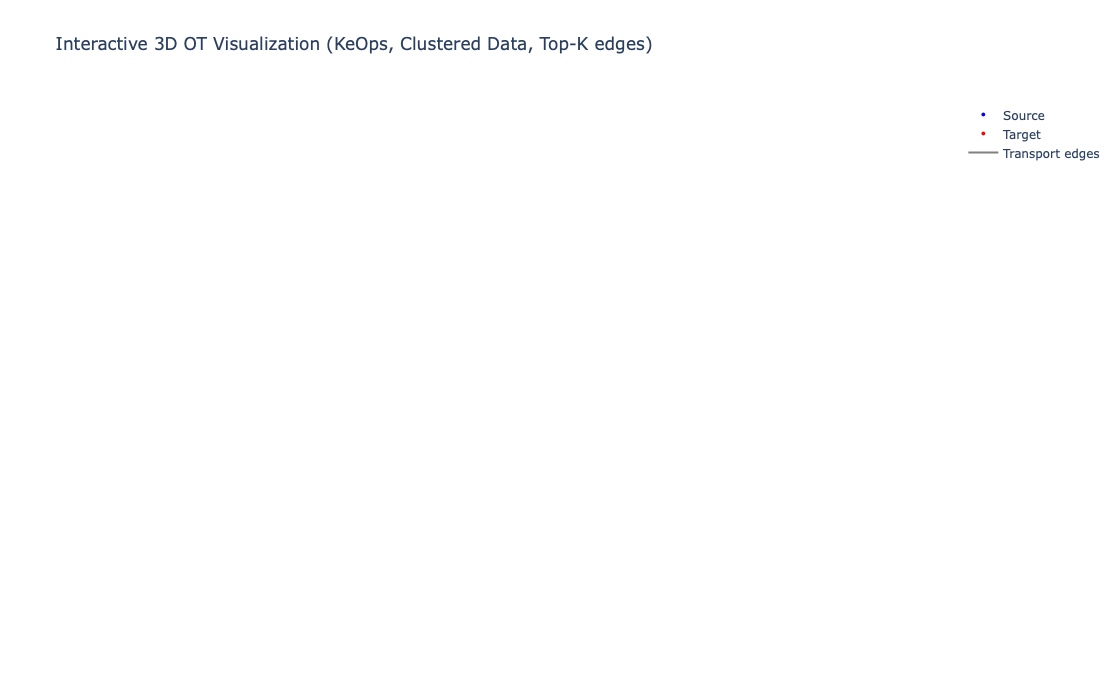

In [25]:
import plotly.graph_objects as go

fig = go.Figure()

# Source points (blue)
fig.add_trace(go.Scatter3d(
    x=x_np[:, 0], y=x_np[:, 1], z=x_np[:, 2],
    mode='markers',
    marker=dict(size=4, color='blue'),
    name='Source'
))

# Target points (red)
fig.add_trace(go.Scatter3d(
    x=y_np[:, 0], y=y_np[:, 1], z=y_np[:, 2],
    mode='markers',
    marker=dict(size=4, color='red'),
    name='Target'
))

# Draw line segments for top-K edges
edge_x = []
edge_y = []
edge_z = []

for i, j in zip(i_inds, j_inds):
    edge_x += [x_np[i, 0], y_np[j, 0], None]
    edge_y += [x_np[i, 1], y_np[j, 1], None]
    edge_z += [x_np[i, 2], y_np[j, 2], None]

fig.add_trace(go.Scatter3d(
    x=edge_x,
    y=edge_y,
    z=edge_z,
    mode='lines',
    line=dict(color='gray', width=2),
    name='Transport edges'
))

fig.update_layout(
    title="Interactive 3D OT Visualization (KeOps, Clustered Data, Top-K edges)",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    width=900,
    height=700
)

fig.show()